# Table of Contents
| Section                      | Subsections                |
|-------------------------------|----------------------------|
|[Introduction](#introduction)| [Initial Ideas](#iniitial-ideas) |
| [Exploratory Data Analysis](#exploratory-data-analysis) | [Categorical Variables](#categorical-variables), [Numerical Variable](#numerical-variables) |
| [Feature Engineering](#feature-engineering) | [PCA](#), [K-Means](#), [Transformations](#transformations) |
|[Random Forest](#random-forest)| [Model Performance and Interpretation](#interpretationmodel-performance) |
|[Conclusion](#conclusion)| --|

<span style="color:orange;">Please note that while all cells in the notebook will run efficiently, the dashboard will not be displayed within the notebook itself. The dashboard has been implemented using Streamlit, so to view it, you need to run the `dash.py` script locally or access it online at [dashboard link](https://reemineralexploration.streamlit.app/).</span>



## Introduction

Critical minerals are crucial for technologies that drive global energy, security, and economic systems. This exploratory analysis will focus on Rare Earth Elements (REEs), highlighting their unique and essential properties. Here are some key points to consider:

- The concentration of REE production primarily in China ([figure 1](https://unctad.org/publication/digital-economy-report-2024)) exposes global supply chains to geopolitical and logistical vulnerabilities, underscoring the need for diversified supply sources [[INN](https://investingnews.com/rare-earths-forecast/)].

- According to the IEA’s Global Critical Minerals Outlook, the major concern in the rare earths sector is not the demand-supply gap but the high geographical concentration of mining and refining activities. This concentration significantly heightens the risk of supply disruptions in the market [[INN](https://investingnews.com/rare-earths-forecast/)].

- Strategically, governments are increasingly viewing REEs as critical minerals, prompting investments across the exploration, extraction, and processing stages of the rare earth supply chain [[MN](https://www.miningnewswire.com/three-key-trends-that-could-impact-rare-earths-in-2024/)].

### Iniitial ideas
- The model would incorporate raster data and linear features, such as the distance to the nearest fault, nearest geological contact, age, and geochemical data. This approach was inspired by several previous studies and analyses such as the [Prospectivity Mapping of Ni-Co Laterites in the Lachlan Orogen](https://github.com/EarthByte/MPM_Lachlan_Laterite), and [Tin-Tungsten Prospecting with Machine Learning in NE Tasmania, Australia](https://colab.research.google.com/drive/168PSo21-Jkwdz8xOmr5-rX9_DL3SInCN?usp=sharing).

- The goal was to develop an ensemble model with a broad understanding of REE deposits, allowing for generalized predictions over larger areas. However, challenges arose related to the scale of available data for each deposit, as well as limitations in computational resources. After further consideration, I decided to adopt a simpler approach focused on the British Columbia region, with the intention of conducting a more regional study.

- A `PCA` was performed on the raster data<sup>1</sup> to reduce dimensionality, followed by `unsupervised models` like `K-means` clustering. Unfortunately, these models did not produce any meaningful clusters, likely due to the complexity of the underlying spatial patterns or the limited number of training samples. 

- Afterward, a `Random Forest` model was applied to the dataset, but it performed poorly. The analysis focused on 65 known points of Critical Mineral showings and prospecting areas in British Columbia. For REE commodity types 1, 2, and 3, 38 points were labeled as mineralized with varying confidence levels (high/low), while the remaining points were categorized as "non-mineralized" (at least for REE prospects). While this initially seemed to provide a reasonably balanced dataset for the Random Forest model, it may have introduced additional complexity. As a result, the model will be revisited outside of the challenge using only two categories and the `grid_no_bc` grid (check the Legacy notebook for further understanding), with the goal of reducing complexity and improving performance.

<sup>1</sup>  _Please note that the RAD raster data might not have been transformed accurately from the source_




## Exploratory Data Analysis

In the Data_Cleaninng_Preprocessing notebook all the standarization for geospatial consistency was made, however, here I'll explore for potential correlation or patterns in the data, as well as some transformation necesary in order to try to implement a simple machine learning model.



In [6]:
import geopandas as gpd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import re
from matplotlib.colors import ListedColormap
import rasterio
import joblib

### Categorical Variables
So far our shp\geodataframe will have only categorical variables. 

In [3]:
# Load the deposit points
deposits = gpd.read_file(r"datasets\shp\cmBC.shp") #all critical minerals ocurrences in BC
#deposits_all = gpd.read_file(r"datasets\shp\cmBC.shp") # When selecting RS deposits

#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS') | (deposits_all['COMMOD_C3']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS')]

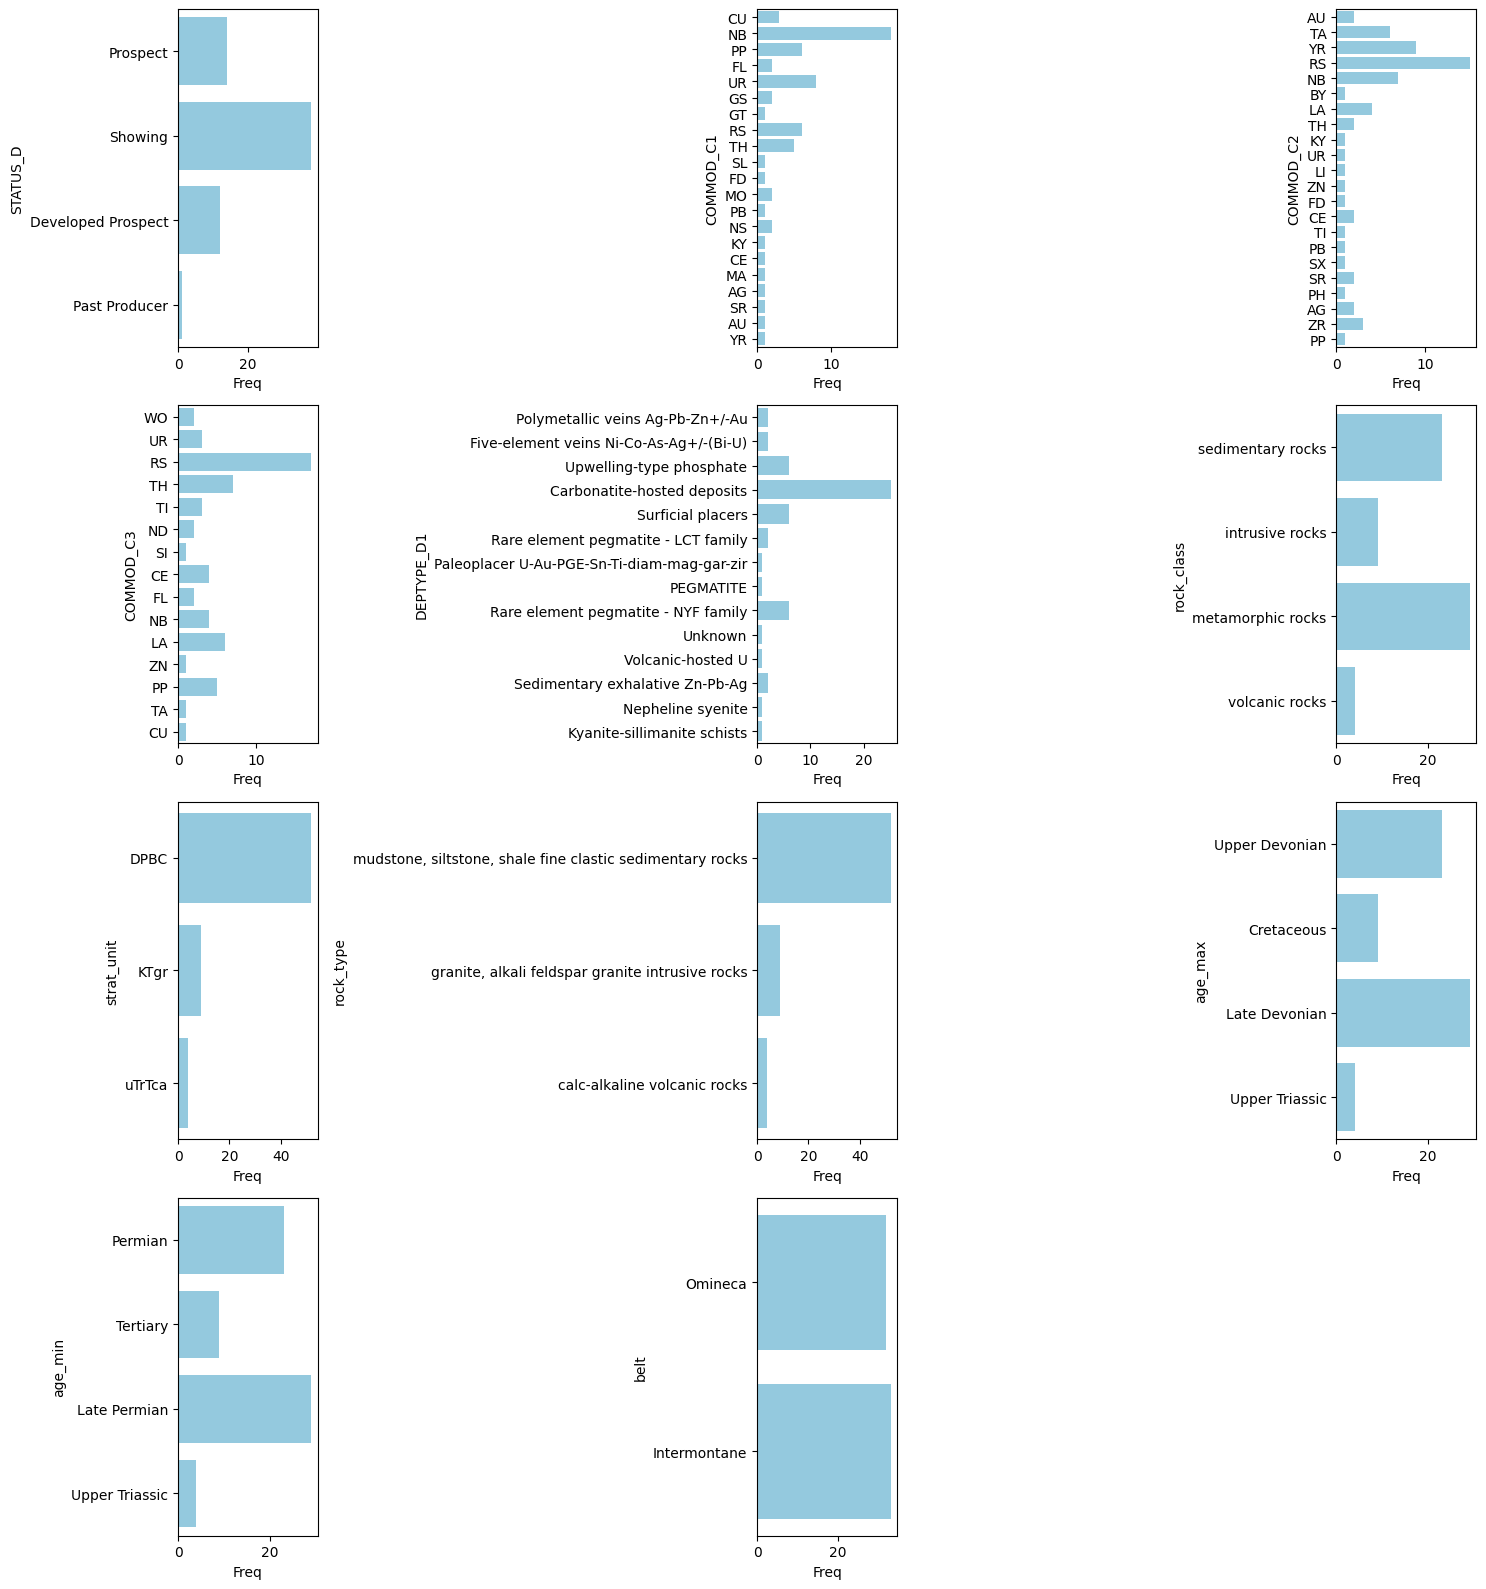

In [8]:
categorical_columns = deposits.select_dtypes(include=['object', 'category']).columns

n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols #number of rows

# subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

#flatten the axis
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(y=col, data=deposits, ax=axes[i], color='skyblue')
   # axes[i].set_title(f'Distribution {col}', fontsize=12)
    axes[i].set_xlabel('Freq')
    axes[i].set_ylabel(col)

# delete empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Some categories in the dataset show similar frequency distributions to other attributes, suggesting potential correlations that could simplify the predictive model without significantly compromising the informational value. The analysis will specifically focus on:

- `DEPTYPE_D1`: This category provides insights into the types of geological deposits present, which directly influence the mineralization processes and potential. It's unique in its distribution.

- `Rock Class`: It shows a frequency distribution similar to 'age_min' and 'age_max'. Given that these age categories might not add significant value beyond what 'rock_class' can provide in a regional system, it simplifies the model to keep 'rock_class' and omit the others.

- `Belt`: Although it features only two categories, it is retained for its ability to capture crucial regional geological distinctions that are significant for the analysis.

In [13]:
deposits.drop(columns=['STATUS_D','strat_unit', 'rock_type', 'age_max', 'age_min'], inplace=True)
deposits.columns

Index(['COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1', 'rock_class',
       'belt', 'geometry'],
      dtype='object')

### Numerical Variables

The numerical variables in this analysis are derived directly from raster datasets. To effectively summarize and reduce the dimensionality of these complex data sets, we will employ Principal Component Analysis (PCA), and this will help to identify the most significant patterns and variations within the rasters.

#### PCA Analysis for points CM REE
Multiple PCA tests were conducted, considering different numbers of components ranging from 2 to 5. These tests were applied to three distinct subsets of our data:

- `All Samples` (65 in total): This includes the entire dataset to ensure a comprehensive analysis across all variables.
- `Samples with REE in Any Commodity` (38 samples): This subset focuses on samples where Rare Earth Elements (REE) appear in any of the commodity classifications, providing insights into the specific behaviors of REE-associated variables.
- `Samples with REE as the Primary Commodity` (6 samples): This targeted analysis concentrates on samples where REE is the main commodity, allowing for a detailed study of its predominant effects.

In general, the percentage of variance explained and the characteristics identified by the PCA remained consistent across all analyses. Notably, the first three principal components (PC1 to PC3) account for approximately 90% of the variance, capturing the majority of the dataset's underlying patterns. The introduction of the fourth component (PC4).

In [8]:
"""If you want to try the diffences of PCA with REE commodities you can uncomment the following lines. 
The code runned is following the all togheter approach with deposits = all records for critical minerals
"""
#deposits_all = deposits.copy()

#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS') | (deposits_all['COMMOD_C3']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS') | (deposits_all['COMMOD_C2']=='RS')]
#deposits=deposits_all[(deposits_all['COMMOD_C1']=='RS')]

# Define the raster files list
raster_paths = [os.path.join(r'datasets\raster\resampled', f) for f in os.listdir(r'datasets\raster\resampled') if f.lower().endswith('.tif')]


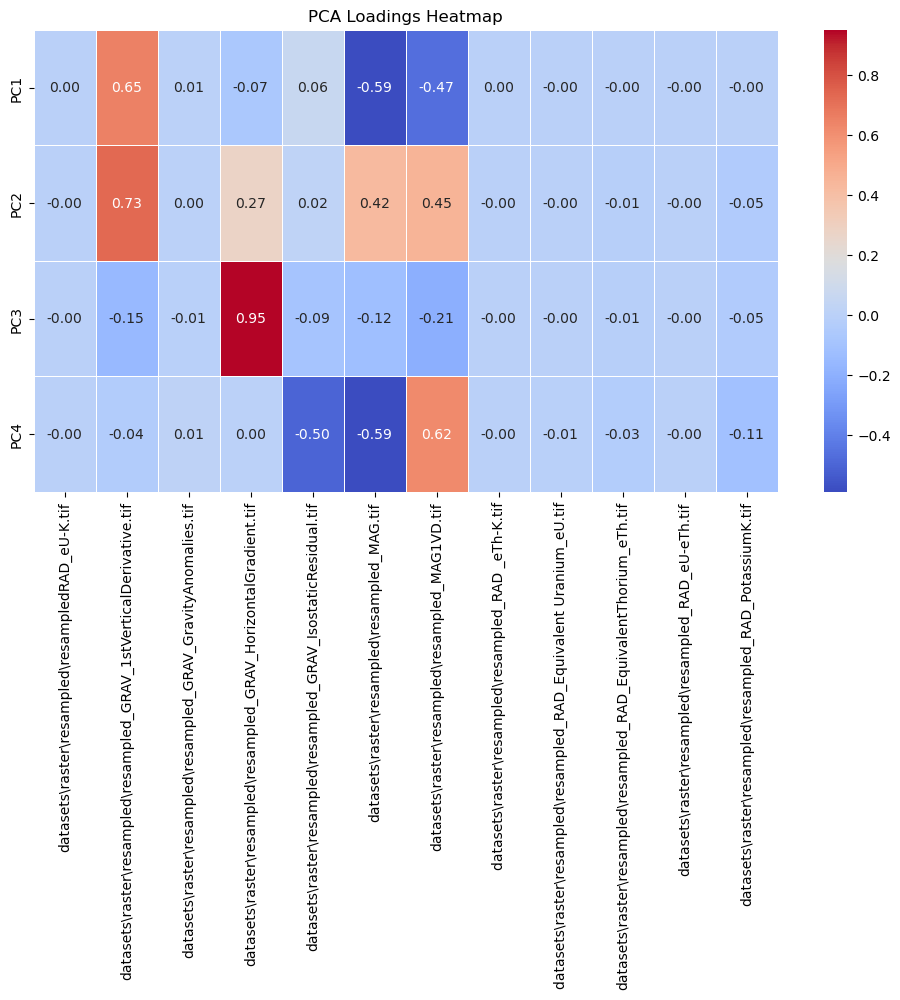

Explained variance by component: [45.10100529 22.55422077 14.00534342  8.76245242], which represent up to 90.42% of the total data


In [14]:
# Initialize an array to hold raster values for each deposit point
features = np.zeros((len(deposits), len(raster_paths)))

# Extract raster values at deposit locations
for i, raster_path in enumerate(raster_paths):
    with rasterio.open(raster_path) as src:
        # Use sample to extract raster values at points
        raster_values = [x[0] for x in src.sample([(point.x, point.y) for point in deposits.geometry])]
        features[:, i] = raster_values

features_df = pd.DataFrame(data=features, columns=[raster_path.split('/')[-1] for raster_path in raster_paths])

# Initialize PCA, let's reduce to 5 principal components for visualization
pca = PCA(n_components=4)

# Fit and transform the features
principal_components = pca.fit_transform(features)

#Convert coefficients to a DataFrame for better visualization
loadings = pca.components_
loadings_df = pd.DataFrame(data=loadings, columns=features_df.columns, index=['PC1', 'PC2','PC3','PC4'])#,'PC5'])

plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('PCA Loadings Heatmap')
plt.show()

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component: {(100*explained_variance)}, which represent up to {round(sum(explained_variance)*100,2)}% of the total data")

We can be confident that with all the rasters, except for the `RAD` ones and `Gravitiy Anomnalies`, we can achieve a high level of explained variance and reduce dimensionality. Although the contribution of K is small, it will still be included in the results

In [15]:
#Selecting columns to drop in the dataset
columns = [i for i in features_df.columns if 'RAD' in i and 'Potassium' not in i or 'Gravity'in i] 
print(columns)
features_important=features_df.drop(columns=columns)


#Join this DataFrame with the deposits DataFrame to keep geographic info
final_df = pd.concat([deposits.reset_index(drop=True), features_important], axis=1)
final_df.head(1)

['datasets\\raster\\resampled\\resampledRAD_eU-K.tif', 'datasets\\raster\\resampled\\resampled_GRAV_GravityAnomalies.tif', 'datasets\\raster\\resampled\\resampled_RAD _eTh-K.tif', 'datasets\\raster\\resampled\\resampled_RAD_Equivalent Uranium_eU.tif', 'datasets\\raster\\resampled\\resampled_RAD_EquivalentThorium_eTh.tif', 'datasets\\raster\\resampled\\resampled_RAD_eU-eTh.tif']


,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,rock_class,belt,geometry,datasets\raster\resampled\resampled_GRAV_1stVerticalDerivative.tif,datasets\raster\resampled\resampled_GRAV_HorizontalGradient.tif,datasets\raster\resampled\resampled_GRAV_IsostaticResidual.tif,datasets\raster\resampled\resampled_MAG.tif,datasets\raster\resampled\resampled_MAG1VD.tif,datasets\raster\resampled\resampled_RAD_PotassiumK.tif
0,CU,AU,WO,Polymetallic veins Ag-Pb-Zn+/-Au,sedimentary rocks,Omineca,POINT (1712345.013 508793.306),165.0,245.0,166.0,142.107132,229.92099,21.412943


In [16]:
final_df.drop(columns=['COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1', 'rock_class',
       'belt'], inplace=True)

In [17]:
final_df.columns

Index(['geometry',
       'datasets\raster\resampled\resampled_GRAV_1stVerticalDerivative.tif',
       'datasets\raster\resampled\resampled_GRAV_HorizontalGradient.tif',
       'datasets\raster\resampled\resampled_GRAV_IsostaticResidual.tif',
       'datasets\raster\resampled\resampled_MAG.tif',
       'datasets\raster\resampled\resampled_MAG1VD.tif',
       'datasets\raster\resampled\resampled_RAD_PotassiumK.tif'],
      dtype='object')

## Feature Engineering and Clustering Analysis

### Missing Values
In the initial phase of feature engineering, null values in the dataset were addressed. After preprocessing, several strategies were explored to label the data, starting with K-means clustering to identify natural groupings. However, the elbow method did not reveal clear clusters, and further clustering attempts using Gaussian Mixture Models (GMM) and DBSCAN also resulted in weak separations, with low silhouette scores across the models.

Despite these efforts, the lack of clear clustering suggests that unsupervised methods may not be suitable for this dataset. Therefore, the analysis will proceed with Random Forest, leveraging domain knowledge to predict mineralization labels and evaluate feature importance in a supervised context.


In [41]:
final_df.isna().sum()

COMMOD_C1                                                             0
COMMOD_C2                                                             0
COMMOD_C3                                                             6
DEPTYPE_D1                                                            8
rock_class                                                            0
belt                                                                  0
geometry                                                              0
datasets\raster\resampled\resampled_GRAV_1stVerticalDerivative.tif    0
datasets\raster\resampled\resampled_GRAV_HorizontalGradient.tif       0
datasets\raster\resampled\resampled_GRAV_IsostaticResidual.tif        0
datasets\raster\resampled\resampled_MAG.tif                           0
datasets\raster\resampled\resampled_MAG1VD.tif                        0
datasets\raster\resampled\resampled_RAD_PotassiumK.tif                0
dtype: int64

The missing values in these fields likely indicate the absence of a third commodity (`COMMOD_C3`) and unknown characteristics regarding the origin of the deposits (`DEPTYPE_D1`). Therefore, 'None' will be assigned to `COMMOD_C3` to accurately reflect the absence of a third commodity. For `DEPTYPE_D1`, an `'Unknown'` category will be used to represent the undetermined origins of the deposits in the datase

In [48]:
final_df['DEPTYPE_D1'] = final_df['DEPTYPE_D1'].fillna('Unknown')
final_df['DEPTYPE_D1'].value_counts()

DEPTYPE_D1
Carbonatite-hosted deposits                    25
Unknown                                         9
Upwelling-type phosphate                        6
Surficial placers                               6
Rare element pegmatite - NYF family             6
Polymetallic veins Ag-Pb-Zn+/-Au                2
Five-element veins Ni-Co-As-Ag+/-(Bi-U)         2
Rare element pegmatite - LCT family             2
Sedimentary exhalative Zn-Pb-Ag                 2
Paleoplacer U-Au-PGE-Sn-Ti-diam-mag-gar-zir     1
PEGMATITE                                       1
Volcanic-hosted U                               1
Nepheline syenite                               1
Kyanite-sillimanite schists                     1
Name: count, dtype: int64

#### Labeling

In [17]:
"""
Conditions:
1: "High Confidence" REE are present as commoditie 1 or 2
2: "Low Confindece" REE are present as commmoditie 3
0: "No mineralizacion" REE are no present, however those are still points for critical minerals
"""
final_df['label_1'] = np.where(
    # Condition for high confidence (hc): either COMMOD_C1 or COMMOD_C2 has 'RS'
    (final_df['COMMOD_C1'] == 'RS') | (final_df['COMMOD_C2'] == 'RS'),
    1,  # Assign 'mineralized_hc' if the condition is met
    # Otherwise, check for low confidence (lc) or no mineralized
    np.where(
        # Condition for low confidence (lc): COMMOD_C3 has 'RS'
        final_df['COMMOD_C3'] == 'RS',
        2,  # Assign 'mineralized_lc' if this condition is met
        0  # Assign 'no_mineralized' if none of the conditions are met
    )
)

final_df['label_1'].value_counts()

### Scaling
before amply kmeans we need to scale everything

In [20]:
# Function to clean column names by extracting the desired part
def clean_column_name(column_name):
    #regex to capture GRAV, MAG, RAD followed by any characters and stop before ".tif"
    match = re.search(r'(GRAV|MAG|RAD).*?(?=\.tif|$)', column_name)
    if match:
        return match.group(0)  # Return the matched part
    else:
        return column_name  # Return the original name if no match is found

# Apply the cleaning function to all column names
final_df.columns = [clean_column_name(col) for col in final_df.columns]

final_df.columns

Index(['geometry', 'GRAV_1stVerticalDerivative', 'GRAV_HorizontalGradient',
       'GRAV_IsostaticResidual', 'MAG', 'MAG1VD', 'RAD_PotassiumK', 'label_1'],
      dtype='object')

In [45]:
from sklearn.preprocessing import StandardScaler

# Let's assume these are your categorical and numerical
#categorical = ['COMMOD_C1', 'COMMOD_C2', 'COMMOD_C3', 'DEPTYPE_D1', 'rock_class','belt']  # Categorical columns
numerical = ['GRAV_1stVerticalDerivative',
       'GRAV_HorizontalGradient', 'GRAV_IsostaticResidual', 'MAG', 'MAG1VD']
       #'RAD_PotassiumK']  # Numerical-rasters columns

# Apply one-hot encoding to categorical columns
#categorical_encoded = pd.get_dummies(final_df[categorical])

# Combine numerical and categorical encoded columns
#combined_data = pd.concat([final_df[numerical], categorical_encoded], axis=1)
combined_data = final_df[numerical]

# Step to scale the combined data
scaler = StandardScaler()
combined_data_scaled = scaler.fit_transform(combined_data)  # Scaled feature set


In [46]:
combined_data.shape

(65, 5)

### Clustering


#### `K-Means`

In [67]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
# Fit the K-means model on the scaled data
kmeans.fit(combined_data_scaled)
# Assign the cluster labels to the original DataFrame
final_df['kmeans_label'] = kmeans.labels_

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(combined_data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to find the elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


#### `GMM`

In [47]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Define the number of components (clusters) for GMM
gmm = GaussianMixture(n_components=3, random_state=42)

# Fit the GMM model to the scaled data
gmm.fit(combined_data_scaled)

# Predict the cluster labels for each data point
final_df['gmm_label'] = gmm.predict(combined_data_scaled)

# Optional: Get the probabilities for each data point's assignment to clusters
final_df['gmm_prob'] = gmm.predict_proba(combined_data_scaled).max(axis=1)  # Maximum probability for each point


In [48]:
# Calculate silhouette score
silhouette_avg = silhouette_score(combined_data_scaled, final_df['gmm_label'])
print(f"The average silhouette score for GMM clustering is {silhouette_avg:.3f}")


The average silhouette score for GMM clustering is 0.270


In [49]:
for n in range(2, 6):  # Testing for clusters from 2 to 5
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(combined_data_scaled)
    labels = gmm.predict(combined_data_scaled)
    silhouette_avg = silhouette_score(combined_data_scaled, labels)
    print(f"n_components = {n}, Silhouette Score = {silhouette_avg:.3f}")


n_components = 2, Silhouette Score = 0.269
n_components = 3, Silhouette Score = 0.270
n_components = 4, Silhouette Score = 0.282
n_components = 5, Silhouette Score = 0.345


## Random Forest

3-way Data Split:
Training Set: Used for training the model.
Validation Set: Used for tuning hyperparameters and evaluating model performance during development. You can use this set to try different model configurations and evaluate improvements.
Holdout (Final Test) Set: This is the portion of the data that you set aside and do not use until you are completely done with model development. This provides a completely unbiased final evaluation of your model.

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = combined_data_scaled  # Features (scaled numerical + categorical)
y = final_df['label_1']  # Target (labels)

# Split into training+validation and holdout (final test)
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

#Further split the training+validation set into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 of 0.8 is 0.2 of the total data

# Now we have:
# - X_train, y_train: For training the model
# - X_val, y_val: For tuning and evaluating the model during development
# - X_holdout, y_holdout: For the final evaluation after you're done with all tuning

In [51]:
# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_val)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.33      0.50      0.40         4
           2       0.75      0.75      0.75         4

    accuracy                           0.54        13
   macro avg       0.58      0.55      0.55        13
weighted avg       0.59      0.54      0.55        13

Confusion Matrix:
[[2 3 0]
 [1 2 1]
 [0 1 3]]


cross validation

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_recall_fscore_support
import numpy as np

# Define your features and labels
X = combined_data_scaled  # Features (scaled numerical)
y = final_df['label_1']   # Target (labels)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up stratified k-fold cross-validation (to ensure each fold has a similar class distribution)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a custom scoring function to get precision, recall, and f1-score for each fold
scoring = make_scorer(precision_recall_fscore_support, average='weighted')

# Perform cross-validation (you can also use cross_val_score for a simpler approach)
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    
    # Get precision, recall, and F1 for the current fold
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate the average precision, recall, and F1 scores
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-Score: {avg_f1:.2f}")


Average Precision: 0.48
Average Recall: 0.46
Average F1-Score: 0.45


### Interpretation/Model performance

- The metrics performance from the cross-validation analysis are all around 0.50, which indicates that the model is struggling to generalize well during cross-validation, and `performance is generally low`.

- `Class 2` has the highest precision of all the classes (Precision: 0.75) meaning predictions for `'Mineralizacion_lc'` are more accurate.


<span style="color:orange;">I understand this is not a good model, however, I'm trying to meet the deadline with this one and then continue with the initial idea because it's a super interesting problem!</span>


In [53]:
importances = rf_model.feature_importances_
feature_names = combined_data.columns

# Sort and print feature importances
sorted_indices = np.argsort(importances)[::-1]
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


MAG: 0.2913
MAG1VD: 0.2426
GRAV_1stVerticalDerivative: 0.1699
GRAV_HorizontalGradient: 0.1605
GRAV_IsostaticResidual: 0.1357


# Implementing in rasters for prospectivity maps

In [99]:
import rasterio
import numpy as np
import pandas as pd

# List of raster paths for the new data
raster_paths = [r'datasets\raster\aligned\aligned_GRAV - 1st Vertical Derivative_float.tif',
                r'datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Horizontal Gradient_float.tif',
                r'datasets\raster\aligned\aligned_resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - Isostatic Residual_float.tif',
                r'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG_float.tif',
                r'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada_1km_MAG1VD_float.tif'
                #r'datasets\raster\aligned\aligned_resampled_cropped_reprojected_Canada - 250m - RAD - eU-K - 2012 - Geotif_float.tif'
                ]  # Add paths to your rasters


# Initialize an empty list to hold the raster values (features for each pixel)
raster_features = []

# Loop through the rasters and extract values for each pixel
for raster_path in raster_paths:
    with rasterio.open(raster_path) as src:
        raster_values = src.read(1).flatten()  # Read and flatten the raster values into a 1D array
        raster_features.append(raster_values)

# Combine all raster values into a DataFrame (each column corresponds to a raster)
raster_data = np.stack(raster_features, axis=1)
raster_df = pd.DataFrame(raster_data, columns=['GRAV_1stVerticalDerivative', 'GRAV_HorizontalGradient', 'GRAV_IsostaticResidual','MAG','MAG1VD'])#,'RAD_K'])

In [85]:
raster_df.isna().sum()

GRAV_1stVerticalDerivative    1233597
GRAV_HorizontalGradient       1233597
GRAV_IsostaticResidual        1233597
MAG                           1232098
MAG1VD                        1232098
dtype: int64

Since the rasters cover areas outside British Columbia (rectangular extened), which are marked as NaN, I applied a mask to exclude these regions. This ensures that predictions are made only for valid data within British Columbia, avoiding erroneous predictions in areas with no data.

In [104]:
# Create a combined mask where all raster columns have valid (non-NaN) values
combined_valid_mask = raster_df.notna().all(axis=1)

# Check how many valid rows you have (should match 946539)
print(f"Number of valid rows: {combined_valid_mask.sum()}")

# Use the combined mask to filter out rows with any NaN values
raster_data_filtered = raster_df[combined_valid_mask]

Number of valid rows: 941485


In [105]:
# Appling the same StandardScaler that was used during training
raster_data_scaled = scaler.transform(raster_data_filtered)
#predictions using the scaled data
raster_predictions = rf_model.predict(raster_data_scaled)

In [127]:
##Save the model for further use
joblib.dump(rf_model, r'models\random_forest_model.pkl')

['models\\random_forest_model.pkl']

In [120]:
#Reconstruct the full raster map with NaNs in invalid areas
with rasterio.open(raster_paths[0]) as src:
    raster_shape = src.shape  # (1366, 1596)

predicted_map_full = np.full(raster_shape, np.nan)  # Initialize with NaNs
predicted_map_full[combined_valid_mask.values.reshape(raster_shape)] = raster_predictions
# Replace NaN values with a distinct integer (e.g., -1 for areas outside British Columbia)
predicted_map_full[np.isnan(predicted_map_full)] = -1

#Save the predicted map as a new raster
with rasterio.open(
    'predicted_prospectivity_map_discrete.tif', 'w',
    driver='GTiff',
    height=predicted_map_full.shape[0],
    width=predicted_map_full.shape[1],
    count=1,
    dtype=rasterio.int32,  # Adjust the data type as needed
    crs=src.crs,  # Use the same CRS as the original raster
    transform=src.transform  # Use the same transform (georeferencing)
) as dst:
    dst.write(predicted_map_full.astype(np.int32), 1)

In [119]:
unique_values, counts = np.unique(predicted_map_full, return_counts=True)

# Print the counts for each value
for value, count in zip(unique_values, counts):
    print(f"Value {value} occurs {count} times")

Value 0.0 occurs 489347 times
Value 1.0 occurs 198394 times
Value 2.0 occurs 253744 times
Value nan occurs 1238651 times


Ploting

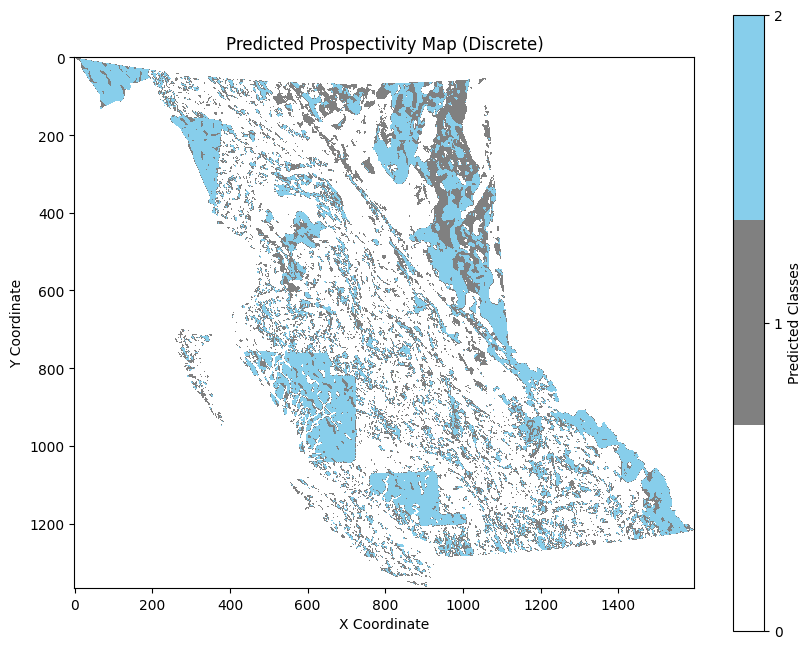

In [124]:
# Open the predicted map file
with rasterio.open('predicted_prospectivity_map_discrete.tif') as src:
    predicted_map = src.read(1)  # Read the first band

# Create a discrete colormap with 3 colors, one for each class (0, 1, 2)
colors = ['white', 'gray', 'skyblue']  # Define colors for the classes
cmap = ListedColormap(colors)

# Plot the raster using the discrete colormap
plt.figure(figsize=(10, 8))
plt.imshow(predicted_map, cmap=cmap, vmin=0, vmax=2)
plt.colorbar(ticks=[0, 1, 2], label='Predicted Classes')  # Add colorbar with class labels
plt.title('Predicted Prospectivity Map (Discrete)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


This is a result of a low performance model. 

## Conclusion

This project involved a significant amount of work, much of which may not be immediately visible in the final product. A large portion of the effort was dedicated to understanding the complex domain of rare earth element (REE) exploration (types, geodynamics, pathfinders), which took substantial time at the beginning. Furthermore, the nuances and challenges of working with geospatial data are critical to producing meaningful results.

Machine Learning (ML) is a powerful tool, and it's exciting to apply it to this field. However, the success of ML models depends heavily on the quality and richness of the data. In hindsight, attempting to tackle such a complex problem within a month, as a single person, and without the necessary computational resources was an ambitious goal. Nevertheless, the experience has been incredibly enriching, and I'm grateful for the opportunity to deepen my understanding of REE exploration and ML applications. This project has laid important groundwork for my professional future development.
